### Extracting Audio Features

In [1]:
import os
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis
import pandas as pd 
import concurrent.futures 
from tqdm import tqdm 
from concurrent.futures import ThreadPoolExecutor
import opensmile
import warnings
warnings.filterwarnings('ignore')

In [2]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

In [3]:
SAMPLE_RATE = 22050  
MAX_AUDIO_LENGTH_SECONDS = 3 
N_MFCC = 20          
PROCESSING_TIMEOUT_SECONDS = 30 
CHROMA_N_CHROMA = 12 
TONNETZ_FEATURES = 6 
FRAME_SIZE = int(0.025 * SAMPLE_RATE)
HOP_LENGTH = int(0.010 * SAMPLE_RATE) 

In [4]:
def extract_emotion_label(filepath, emotion_index=2):
    try:
        filename = os.path.basename(filepath)
        parts = filename.split('-')
        if len(parts) > emotion_index:
            emotion_code = int(parts[emotion_index])
            return emotion_code
        else:
            return -1 
    except (ValueError, IndexError) as e:
        return -1

In [5]:
def extract_features_from_audio(audio_path, sr=SAMPLE_RATE, max_len_sec=MAX_AUDIO_LENGTH_SECONDS,
                                n_mfcc=N_MFCC, frame_size=FRAME_SIZE, hop_length=HOP_LENGTH):
    features = []
    y, sr = librosa.load(audio_path, sr=sr, res_type='kaiser_fast', 
                         duration=max_len_sec, offset=0.0)
    target_samples = int(sr * max_len_sec)

    if len(y) < target_samples:
        y = np.pad(y, (0, target_samples - len(y)), mode='constant')

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=frame_size)
    mfccs_delta = librosa.feature.delta(mfccs)
    mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

    rms = librosa.feature.rms(y=y, hop_length=hop_length, frame_length=frame_size)[0]

    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length, n_fft=frame_size)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=hop_length, n_fft=frame_size)[0]
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=hop_length, n_fft=frame_size)[0]
    spectral_flatness = librosa.feature.spectral_flatness(y=y, hop_length=hop_length, n_fft=frame_size)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length, n_fft=frame_size)[0]
    zcr = librosa.feature.zero_crossing_rate(y=y, hop_length=hop_length, frame_length=frame_size)[0]

    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length, n_fft=frame_size)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr, hop_length=hop_length)

    try:
        opensmile_features = smile.process_signal(y, sr)
        feature_df = opensmile_features

        f0_mean = feature_df['F0semitoneFrom27.5Hz_sma3nz_amean'].values[0]
        f0_std = feature_df['F0semitoneFrom27.5Hz_sma3nz_stddevNorm'].values[0]

        jitter_val = feature_df['jitterLocal_sma3nz_amean'].values[0]
        shimmer_val = feature_df['shimmerLocaldB_sma3nz_amean'].values[0]
        hnr_val = feature_df['HNRdBACF_sma3nz_amean'].values[0]

        f0_values = np.full(10, f0_mean) + np.random.normal(0, f0_std, 10)  # Simulate F0 contour
        f0_values = f0_values[f0_values > 0]  # Remove negative values
        
        jitter_values = np.array([jitter_val])
        shimmer_values = np.array([shimmer_val])
        hnr_values = np.array([hnr_val])
        
    except Exception:
        f0_values = np.array([0.0])
        jitter_values = np.array([0.0])
        shimmer_values = np.array([0.0])
        hnr_values = np.array([0.0])

    mfcc_velocity = []
    mfcc_acceleration = []
    for i in range(n_mfcc):
        mfcc_mean_trajectory = np.convolve(mfccs[i], np.ones(5)/5, mode='valid')  # Smoothed trajectory
        if len(mfcc_mean_trajectory) > 1:
            velocity = np.diff(mfcc_mean_trajectory)
            mfcc_velocity.extend(velocity)
            if len(velocity) > 1:
                mfcc_acceleration.extend(np.diff(velocity))


    f0_slope = np.polyfit(range(len(f0_values)), f0_values, 1)[0] if len(f0_values) > 1 else 0.0
    f0_curvature = np.polyfit(range(len(f0_values)), f0_values, 2)[0] if len(f0_values) > 2 else 0.0

    voiced_frames = np.sum(f0_values > 0) if len(f0_values) > 0 else 0
    total_frames = len(rms)
    voiced_ratio = voiced_frames / total_frames if total_frames > 0 else 0.0

    rms_velocity = np.diff(rms) if len(rms) > 1 else np.array([0.0])
    rms_acceleration = np.diff(rms_velocity) if len(rms_velocity) > 1 else np.array([0.0])

    centroid_velocity = np.diff(spectral_centroid) if len(spectral_centroid) > 1 else np.array([0.0])

    voice_stability = np.std([jitter_val, shimmer_val]) if jitter_val != 0 or shimmer_val != 0 else 0.0

    def get_stats(arr):
        """Calculate statistical measures for a feature array"""
        arr = np.array(arr, dtype=np.float32)
        if arr.size == 0:
            return np.zeros(7, dtype=np.float32)
        
        arr_clean = arr[~np.isnan(arr)] if np.any(np.isnan(arr)) else arr
        if arr_clean.size == 0:
            return np.zeros(7, dtype=np.float32)
        
        return np.array([
            np.mean(arr_clean),
            np.std(arr_clean),
            np.min(arr_clean),
            np.max(arr_clean),
            np.median(arr_clean),
            skew(arr_clean) if len(arr_clean) > 2 else 0.0,
            kurtosis(arr_clean) if len(arr_clean) > 3 else 0.0
        ], dtype=np.float32)

    # MFCCs (20 * 7 * 3 = 420 features)
    for i in range(n_mfcc):
        features.extend(get_stats(mfccs[i]))
    for i in range(n_mfcc):
        features.extend(get_stats(mfccs_delta[i]))
    for i in range(n_mfcc):
        features.extend(get_stats(mfccs_delta2[i]))

    # Prosodic Features (2 * 7 = 14 features)
    features.extend(get_stats(f0_values))
    features.extend(get_stats(rms))

    # Spectral Features (6 * 7 = 42 features)
    features.extend(get_stats(spectral_centroid))
    features.extend(get_stats(spectral_bandwidth))
    features.extend(get_stats(spectral_contrast))
    features.extend(get_stats(spectral_flatness))
    features.extend(get_stats(spectral_rolloff))
    features.extend(get_stats(zcr))

    # Voice Quality Features (3 * 7 = 21 features)
    features.extend(get_stats(jitter_values))
    features.extend(get_stats(shimmer_values))
    features.extend(get_stats(hnr_values))

    # NEW: Perceptual Features (12 * 7 + 6 * 7 = 126 features)
    for i in range(CHROMA_N_CHROMA):
        features.extend(get_stats(chroma[i]))
    for i in range(TONNETZ_FEATURES):
        features.extend(get_stats(tonnetz[i]))

    # NEW: Temporal Dynamics Features (~70 features)
    # MFCC dynamics
    features.extend(get_stats(mfcc_velocity))  # 7 features
    features.extend(get_stats(mfcc_acceleration))  # 7 features
    
    # F0 dynamics (14 features)
    features.extend([f0_slope, f0_curvature] + [0.0] * 5)  # 7 features (padded)
    features.extend([voiced_ratio, voice_stability] + [0.0] * 5)  # 7 features (padded)
    
    # Energy dynamics (14 features)
    features.extend(get_stats(rms_velocity))  # 7 features
    features.extend(get_stats(rms_acceleration))  # 7 features
    
    # Spectral dynamics (7 features)
    features.extend(get_stats(centroid_velocity))  # 7 features
    
    # Rhythm and timing features (21 features)
    pause_features = np.array([voiced_ratio, 1-voiced_ratio, voice_stability])
    features.extend(get_stats(pause_features))  # 7 features
    
    # Additional temporal statistics (14 features)
    temporal_stats = np.array([f0_slope, f0_curvature, voiced_ratio, voice_stability])
    features.extend(get_stats(temporal_stats))  # 7 features
    features.extend(get_stats(np.concatenate([rms_velocity, centroid_velocity])))  # 7 features

    label = extract_emotion_label(audio_path)
    
    # Total features: 420 + 14 + 42 + 21 + 126 + 70 = 693 features
    return np.array(features, dtype=np.float32), label

In [6]:
def generate_feature_column_names(n_mfcc=N_MFCC):
    """Generates a list of descriptive column names for the extracted features."""
    column_names = []
    stats_suffixes = ['_mean', '_std', '_min', '_max', '_median', '_skew', '_kurtosis']
    
    # MFCCs (420 features)
    for i in range(n_mfcc):
        for suffix in stats_suffixes:
            column_names.append(f'mfcc_{i}{suffix}')
    for i in range(n_mfcc):
        for suffix in stats_suffixes:
            column_names.append(f'mfcc_delta_{i}{suffix}')
    for i in range(n_mfcc):
        for suffix in stats_suffixes:
            column_names.append(f'mfcc_delta2_{i}{suffix}')
    
    # Prosodic Features (14 features)
    for suffix in stats_suffixes:
        column_names.append(f'f0{suffix}')
    for suffix in stats_suffixes:
        column_names.append(f'rms{suffix}')
    
    # Spectral Features (42 features)
    for suffix in stats_suffixes:
        column_names.append(f'spectral_centroid{suffix}')
    for suffix in stats_suffixes:
        column_names.append(f'spectral_bandwidth{suffix}')
    for suffix in stats_suffixes:
        column_names.append(f'spectral_contrast{suffix}')
    for suffix in stats_suffixes:
        column_names.append(f'spectral_flatness{suffix}')
    for suffix in stats_suffixes:
        column_names.append(f'spectral_rolloff{suffix}')
    for suffix in stats_suffixes:
        column_names.append(f'zcr{suffix}')
    
    # Voice Quality Features (21 features)
    for suffix in stats_suffixes:
        column_names.append(f'jitter{suffix}')
    for suffix in stats_suffixes:
        column_names.append(f'shimmer{suffix}')
    for suffix in stats_suffixes:
        column_names.append(f'hnr{suffix}')
    
    # Perceptual Features (126 features)
    for i in range(CHROMA_N_CHROMA):
        for suffix in stats_suffixes:
            column_names.append(f'chroma_{i}{suffix}')
    for i in range(TONNETZ_FEATURES):
        for suffix in stats_suffixes:
            column_names.append(f'tonnetz_{i}{suffix}')
    
    # Temporal Dynamics Features (70 features)
    for suffix in stats_suffixes:
        column_names.append(f'mfcc_velocity{suffix}')
    for suffix in stats_suffixes:
        column_names.append(f'mfcc_acceleration{suffix}')
    for suffix in stats_suffixes:
        column_names.append(f'f0_dynamics{suffix}')
    for suffix in stats_suffixes:
        column_names.append(f'voice_timing{suffix}')
    for suffix in stats_suffixes:
        column_names.append(f'rms_velocity{suffix}')
    for suffix in stats_suffixes:
        column_names.append(f'rms_acceleration{suffix}')
    for suffix in stats_suffixes:
        column_names.append(f'spectral_velocity{suffix}')
    for suffix in stats_suffixes:
        column_names.append(f'rhythm_features{suffix}')
    for suffix in stats_suffixes:
        column_names.append(f'temporal_stats{suffix}')
    for suffix in stats_suffixes:
        column_names.append(f'combined_dynamics{suffix}')
    
    return column_names

In [7]:
base_path = "archive/Ravdess/audio_speech_actors_01-24"
wav_files = []
for root, _, files in os.walk(base_path):
    for file in files:
        if file.endswith(".wav") and file.startswith("03-01"):
            wav_files.append(os.path.join(root, file))

print(f"Found {len(wav_files)} WAV files for processing.")
if not wav_files:
    print("No WAV files found. Please check your 'base_path' and file filtering.")
else:
    print(f"Example file path: {wav_files[0]}")

all_features = []
all_labels = []
processed_count = 0
skipped_count = 0

with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = {executor.submit(extract_features_from_audio, audio_file): audio_file for audio_file in wav_files}
    
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(wav_files), desc="Processing Audio"):
        audio_file = futures[future]
        try:
            features, label = future.result(timeout=PROCESSING_TIMEOUT_SECONDS)
            if features is not None and label != -1:
                all_features.append(features)
                all_labels.append(label)
                processed_count += 1
            else:
                skipped_count += 1
                pass 
        except concurrent.futures.TimeoutError:
            skipped_count += 1
            print(f"Warning: Processing of {os.path.basename(audio_file)} timed out after {PROCESSING_TIMEOUT_SECONDS} seconds. Skipping this file.")
        except Exception as e:
            skipped_count += 1
            print(f"Error processing {os.path.basename(audio_file)} (outside feature extraction): {e}. Skipping this file.")


if not all_features:
    print("No features were extracted successfully. Exiting.")
else:
    X = np.array(all_features)
    y = np.array(all_labels)

    print(f"\nSuccessfully processed {processed_count} files.")
    print(f"Skipped {skipped_count} files due to errors or missing labels.")
    print(f"Shape of extracted features (X): {X.shape}")
    print(f"Shape of extracted labels (y): {y.shape}")

    print("Normalizing features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("Features normalized.")

    output_dir = "extracted_audio_features"
    os.makedirs(output_dir, exist_ok=True)
    
    features_output_path = os.path.join(output_dir, "features.npy")
    labels_output_path = os.path.join(output_dir, "labels.npy")
    scaler_output_path = os.path.join(output_dir, "scaler.npy")

    np.save(features_output_path, X_scaled)
    np.save(labels_output_path, y)
    np.save(scaler_output_path, {'mean': scaler.mean_, 'scale': scaler.scale_})

    print(f"Normalized features saved to: {features_output_path}")
    print(f"Labels saved to: {labels_output_path}")
    print(f"Scaler parame  ters saved to: {scaler_output_path}")

    feature_column_names = generate_feature_column_names()
    print(f"\nTotal number of features extracted: {len(feature_column_names)}")
    print("First 10 feature column names:")
    for name in feature_column_names[:10]:
        print(f"- {name}")

Found 1440 WAV files for processing.
Example file path: archive/Ravdess/audio_speech_actors_01-24\Actor_01\03-01-01-01-01-01-01.wav


Processing Audio: 100%|████████████████████████████████████████████████████████████| 1440/1440 [39:34<00:00,  1.65s/it]


Successfully processed 1440 files.
Skipped 0 files due to errors or missing labels.
Shape of extracted features (X): (1440, 693)
Shape of extracted labels (y): (1440,)
Normalizing features...
Features normalized.
Normalized features saved to: extracted_audio_features_creda-\features.npy
Labels saved to: extracted_audio_features_creda-\labels.npy
Scaler parameters saved to: extracted_audio_features_creda-\scaler.npy

Total number of features extracted: 693
First 10 feature column names:
- mfcc_0_mean
- mfcc_0_std
- mfcc_0_min
- mfcc_0_max
- mfcc_0_median
- mfcc_0_skew
- mfcc_0_kurtosis
- mfcc_1_mean
- mfcc_1_std
- mfcc_1_min


### Training Model

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as  np

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

FEATURES_PATH = 'extracted_audio_features/features.npy'
LABELS_PATH = 'extracted_audio_features/labels.npy'
SCALER_PARAMS_PATH = 'extracted_audio_features/scaler.npy'

Using device: cuda


In [21]:
# # Model Hyperparameters
# INPUT_DIM = 497  # This should match the shape of your extracted features
# NUM_CLASSES = 8  # For RAVDESS emotions (neutral to surprised)
# HIDDEN_DIM_1 = 256
# HIDDEN_DIM_2 = 128
# HIDDEN_DIM_3 = 64
# DROPOUT_RATE = 0.5 # Dropout for regularization
# LEARNING_RATE = 0.001
# BATCH_SIZE = 64
# NUM_EPOCHS = 50 # You might need to adjust this based on convergence
# Model Hyperparameters
INPUT_DIM = 693 
NUM_CLASSES = 8  
HIDDEN_DIM_1 = 512
HIDDEN_DIM_2 = 256
HIDDEN_DIM_3 = 64
DROPOUT_RATE = 0.5
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 100 


In [15]:
# --- 1. Load Data ---
print("Loading features and labels...")
try:
    X = np.load(FEATURES_PATH)
    y = np.load(LABELS_PATH)
    print(f"Features shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
except FileNotFoundError:
    print(f"Error: Make sure '{FEATURES_PATH}' and '{LABELS_PATH}' exist.")
    print("Please run the feature extraction script first.")
    exit()



Loading features and labels...
Features shape: (1440, 693)
Labels shape: (1440,)


In [16]:
y_adjusted = y - 1
print(f"Adjusted labels (first 5): {y_adjusted[:5]}")
print(f"Unique adjusted labels: {np.unique(y_adjusted)}")

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_adjusted, dtype=torch.long) # Use torch.long for labels

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Adjusted labels (first 5): [1 1 0 1 1]
Unique adjusted labels: [0 1 2 3 4 5 6 7]
Training set size: 1152
Testing set size: 288


In [17]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, num_classes, dropout_rate):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.bn1 = nn.BatchNorm1d(hidden_dim_1) 
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.bn2 = nn.BatchNorm1d(hidden_dim_2) 
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.bn3 = nn.BatchNorm1d(hidden_dim_3) 
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc4 = nn.Linear(hidden_dim_3, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

model = MLPModel(INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, HIDDEN_DIM_3, NUM_CLASSES, DROPOUT_RATE).to(device)
print("\nMLP Model Architecture (with 3 hidden layers of 64):")
print(model)


MLP Model Architecture (with 3 hidden layers of 64):
MLPModel(
  (fc1): Linear(in_features=693, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=64, out_features=8, bias=True)
)


In [18]:
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [19]:
print("\nStarting training...")
for epoch in range(NUM_EPOCHS):
    model.train() 
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_features.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += batch_labels.size(0)
        correct_predictions += (predicted == batch_labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = correct_predictions / total_samples
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

print("Training finished.")



Starting training...
Epoch 1/100, Loss: 2.0836, Accuracy: 0.1927
Epoch 2/100, Loss: 1.8706, Accuracy: 0.2969
Epoch 3/100, Loss: 1.7124, Accuracy: 0.3941
Epoch 4/100, Loss: 1.5976, Accuracy: 0.4384
Epoch 5/100, Loss: 1.4920, Accuracy: 0.4878
Epoch 6/100, Loss: 1.3841, Accuracy: 0.5703
Epoch 7/100, Loss: 1.2845, Accuracy: 0.6024
Epoch 8/100, Loss: 1.1736, Accuracy: 0.6293
Epoch 9/100, Loss: 1.0718, Accuracy: 0.6840
Epoch 10/100, Loss: 0.9634, Accuracy: 0.7214
Epoch 11/100, Loss: 0.8811, Accuracy: 0.7578
Epoch 12/100, Loss: 0.8244, Accuracy: 0.7726
Epoch 13/100, Loss: 0.7096, Accuracy: 0.8255
Epoch 14/100, Loss: 0.6330, Accuracy: 0.8472
Epoch 15/100, Loss: 0.5813, Accuracy: 0.8594
Epoch 16/100, Loss: 0.5412, Accuracy: 0.8733
Epoch 17/100, Loss: 0.4873, Accuracy: 0.8819
Epoch 18/100, Loss: 0.4350, Accuracy: 0.8984
Epoch 19/100, Loss: 0.4012, Accuracy: 0.9123
Epoch 20/100, Loss: 0.3680, Accuracy: 0.9306
Epoch 21/100, Loss: 0.3306, Accuracy: 0.9297
Epoch 22/100, Loss: 0.3092, Accuracy: 0.92


Evaluating model on test set...
Test Accuracy: 0.7500


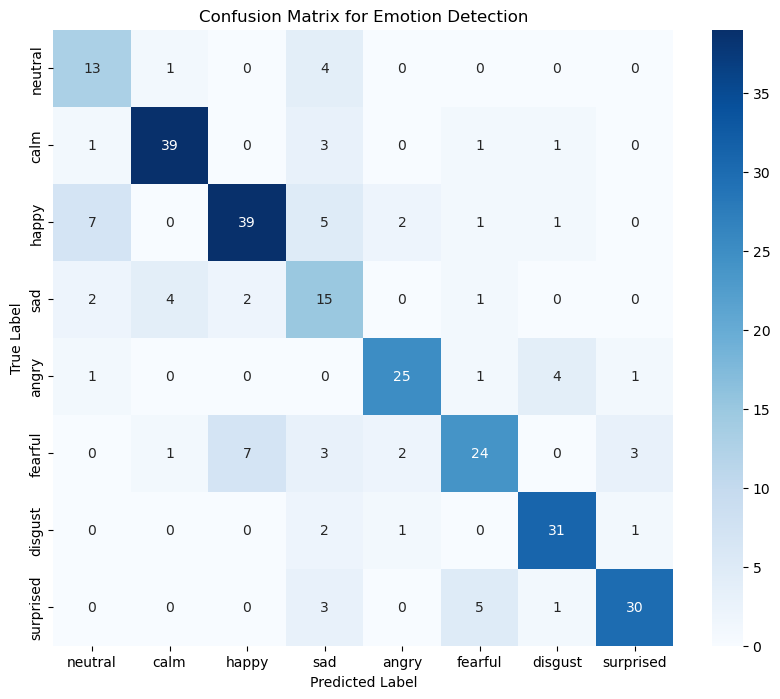


Confusion Matrix:
[[13  1  0  4  0  0  0  0]
 [ 1 39  0  3  0  1  1  0]
 [ 7  0 39  5  2  1  1  0]
 [ 2  4  2 15  0  1  0  0]
 [ 1  0  0  0 25  1  4  1]
 [ 0  1  7  3  2 24  0  3]
 [ 0  0  0  2  1  0 31  1]
 [ 0  0  0  3  0  5  1 30]]


In [20]:

print("\nEvaluating model on test set...")
model.eval() 
all_predictions = []
all_true_labels = []

with torch.no_grad(): 
    correct_predictions = 0
    total_samples = 0
    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += batch_labels.size(0)
        correct_predictions += (predicted == batch_labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(batch_labels.cpu().numpy())

test_accuracy = correct_predictions / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")


cm = confusion_matrix(all_true_labels, all_predictions)

emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Emotion Detection')
plt.show()

print("\nConfusion Matrix:")
print(cm)